#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**

using the airbnb dataset

version 0.92 2021-07-05

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from mizani.formatters import percent_format
from plotnine import *
import matplotlib.pyplot as plt

from skranger.ensemble import RangerForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
path = Path(os.getcwd())

base_dir = str(path.parent.parent)

data_in = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/")
data_out = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/")
output = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/output/")
func = os.path.join(base_dir, "da_case_studies/ch00-tech-prep/")

sys.path.append(func)
from py_helper_functions import *

## PART I
### Loading and preparing data 
----------------------------------------------

In [3]:
area = "london"
data = pd.read_csv(data_in + "airbnb_" + area + "_workfile_adj.csv")
data = data.loc[data.price.notna(), :]

In [4]:
def count_missing_values(df):
    return df.isna().sum()[df.isna().sum()>0]

In [5]:
count_missing_values(data)

Series([], dtype: int64)

In [6]:
# Sample definition and preparation ---------------------------------------

# We focus on normal apartments, n<8
data = data.query('n_accommodates < 8')

In [7]:
# copy a variable - purpose later, see at variable importance
data = data.assign(n_accommodates_copy = data.n_accommodates)

In [8]:

# basic descr stat -------------------------------------------
data.describe()

,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_beds,...,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,n_accommodates_copy
count,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.00000,49826.000000,49826.000000,...,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,4.982600e+04,4.982600e+04,49826.000000,49826.000000
mean,88.984044,2.838759,1.224260,92.458616,12.340144,1.356180,1.138253,6.50873,3.300947,1.585959,...,0.318850,0.303998,0.303998,5.713297,33.456371,199.607207,2.931985e+05,3.046539e+08,4.520910,2.838759
std,70.515089,1.494748,0.466448,8.418474,25.889935,0.879263,1.238156,12.31549,29.578062,0.927501,...,0.466035,0.459986,0.459986,0.902564,9.506988,80.264045,5.640361e+05,9.636140e+08,0.120421,1.494748
min,8.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.010000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000
25%,41.000000,2.000000,1.000000,92.000000,0.000000,1.000000,0.470000,0.00000,1.000000,1.000000,...,0.000000,0.000000,0.000000,5.433722,29.525335,160.432461,5.198400e+04,1.185235e+07,4.521789,2.000000
50%,70.000000,2.000000,1.000000,94.000000,3.000000,1.000000,0.770000,0.00000,2.000000,1.000000,...,0.000000,0.000000,0.000000,5.793014,33.559007,194.407782,1.069290e+05,3.496578e+07,4.543295,2.000000
75%,110.000000,4.000000,1.000000,97.000000,12.000000,1.000000,1.170000,10.00000,3.000000,2.000000,...,1.000000,1.000000,1.000000,6.224558,38.745128,241.171311,2.540160e+05,1.280241e+08,4.574711,4.000000
max,999.000000,7.000000,8.000000,100.000000,396.000000,16.000000,15.000000,240.00000,5000.000000,16.000000,...,1.000000,1.000000,1.000000,7.909489,62.560024,494.817853,7.409284e+06,2.016807e+10,4.605170,7.000000


In [9]:
data.price.describe()

count    49826.000000
mean        88.984044
std         70.515089
min          8.000000
25%         41.000000
50%         70.000000
75%        110.000000
max        999.000000
Name: price, dtype: float64

In [10]:
data.f_room_type.value_counts()

Entire home/apt    24938
Private room       24351
Shared room          537
Name: f_room_type, dtype: int64

In [11]:
data.f_property_type.value_counts()

Apartment    37467
House        12359
Name: f_property_type, dtype: int64

In [12]:
data.f_number_of_reviews.value_counts()

2    31575
1    15148
3     3103
Name: f_number_of_reviews, dtype: int64

In [13]:
# create train and holdout samples -------------------------------------------
# train is where we do it all, incl CV

# First pick a smaller than usual training set so that models run faster and check if works
# If works, start anew without these two lines

In [14]:
data_train, data_holdout = train_test_split(data,train_size=0.7, random_state=42)

In [15]:
data_train.shape, data_holdout.shape

((34878, 91), (14948, 91))

In [16]:
# Basic Variables inc neighnourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_cancellation_policy",
    "f_bed_type",
    "f_neighbourhood_cleansed",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

# Dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "f_room_type:d_familykidfriendly",
    "d_airconditioning:f_property_type",
    "d_cats:f_property_type",
    "d_dogs:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [17]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

## PART II
### RANDOM FORESTS 
-------------------------------------------------------

In [18]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [5, 7, 9], "min_node_size": [5, 10]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_1), data_train)

rf_model_1 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .........min_node_size=5, mtry=5;, score=-47.131 total time=   4.2s
[CV 2/5] END .........min_node_size=5, mtry=5;, score=-46.012 total time=   4.7s
[CV 3/5] END .........min_node_size=5, mtry=5;, score=-46.180 total time=   3.8s
[CV 4/5] END .........min_node_size=5, mtry=5;, score=-44.430 total time=   3.6s
[CV 5/5] END .........min_node_size=5, mtry=5;, score=-47.481 total time=   4.0s
[CV 1/5] END .........min_node_size=5, mtry=7;, score=-46.488 total time=   7.0s
[CV 2/5] END .........min_node_size=5, mtry=7;, score=-45.704 total time=   6.4s
[CV 3/5] END .........min_node_size=5, mtry=7;, score=-45.725 total time=   5.5s
[CV 4/5] END .........min_node_size=5, mtry=7;, score=-43.803 total time=   5.6s
[CV 5/5] END .........min_node_size=5, mtry=7;, score=-47.100 total time=   5.3s
[CV 1/5] END .........min_node_size=5, mtry=9;, score=-46.512 total time=   6.6s
[CV 2/5] END .........min_node_size=5, mtry=9;, s

In [19]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [8, 10, 12], "min_node_size": [5, 10, 15]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_2 = rf_random.fit(X,y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .........min_node_size=5, mtry=8;, score=-44.952 total time=   9.3s
[CV 2/5] END .........min_node_size=5, mtry=8;, score=-43.998 total time=   8.2s
[CV 3/5] END .........min_node_size=5, mtry=8;, score=-44.870 total time=   7.6s
[CV 4/5] END .........min_node_size=5, mtry=8;, score=-42.269 total time=   7.8s
[CV 5/5] END .........min_node_size=5, mtry=8;, score=-45.505 total time=   7.9s
[CV 1/5] END ........min_node_size=5, mtry=10;, score=-44.654 total time=   9.1s
[CV 2/5] END ........min_node_size=5, mtry=10;, score=-43.731 total time=   9.3s
[CV 3/5] END ........min_node_size=5, mtry=10;, score=-44.620 total time=   9.1s
[CV 4/5] END ........min_node_size=5, mtry=10;, score=-41.975 total time=   9.1s
[CV 5/5] END ........min_node_size=5, mtry=10;, score=-45.216 total time=   9.0s
[CV 1/5] END ........min_node_size=5, mtry=12;, score=-44.550 total time=  10.6s
[CV 2/5] END ........min_node_size=5, mtry=12;, s

### Table 16.1 Random forest RMSE by tuning parameters

In [20]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_mtry", "param_min_node_size", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_mtry"],
    Min_nodes=lambda x: x["param_min_node_size"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,8,10,12
Min_nodes,,,
5,44.32,44.04,43.83
10,44.45,44.07,43.90
15,44.61,44.23,44.15


In [21]:
pd.DataFrame(
    {
        "Min vars": [rf_model_1.best_estimator_.mtry, rf_model_2.best_estimator_.mtry],
        "Min nodes": [
            rf_model_1.best_estimator_.min_node_size,
            rf_model_2.best_estimator_.min_node_size,
        ],
    },
    ["Model A", "Model B"],
)

,Min vars,Min nodes
Model A,7,5
Model B,12,5


In [22]:
pd.DataFrame(
    {
        "RMSE": [
            rf_model_1.cv_results_["mean_test_score"].min(),
            rf_model_2.cv_results_["mean_test_score"].min(),
        ]
    },
    ["Model A", "Model B"],
).round(3) * -1

,RMSE
Model A,46.247
Model B,44.606


## PART III
### MODEL DIAGNOSTICS 
---

In [23]:
rf_model_2_var_imp_df = (
    pd.DataFrame(
        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname",0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

**1) full varimp plot, above a cutoff**

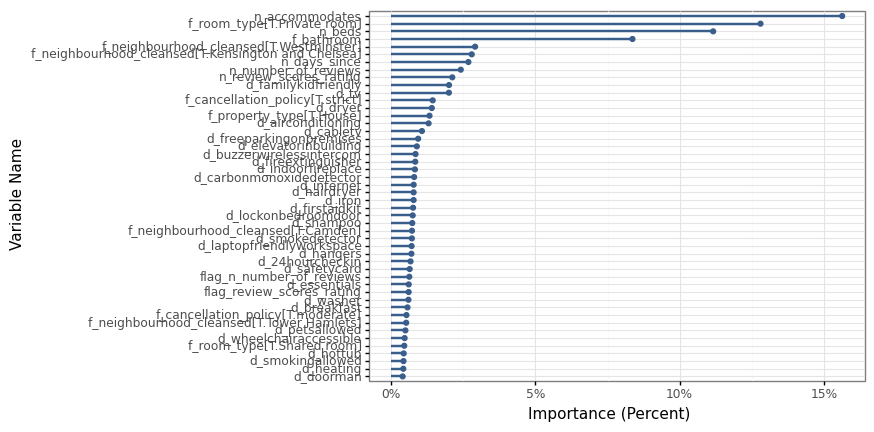

<ggplot: (333843984)>

In [24]:
cutoff = 600000

ggplot(
    rf_model_2_var_imp_df.loc[lambda x: x.imp > cutoff],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**2) full varimp plot, top 10 only**

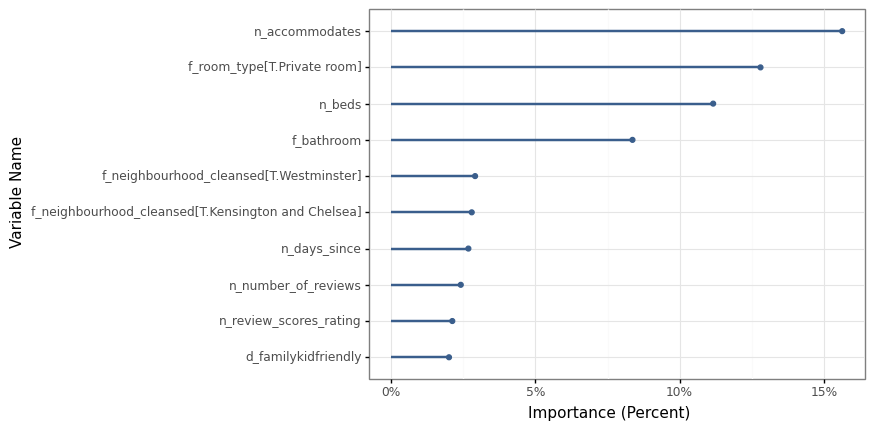

<ggplot: (334030150)>

In [25]:
ggplot(
    rf_model_2_var_imp_df.iloc[:10, :],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**3) grouped variable importance - keep binaries created off factors together**

For this, you need to create an sklearn pipeline and put OneHotEncoding in it (before, encoding was done by patsy's dmatrices). This way permutation_importance can calculate factor variables' importance 

In [26]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [27]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_model_2.best_estimator_)] # put best model to pipeline
)

In [28]:
rf.fit(data_train[predictors_2],data_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathroom',
                                                   'f_cancellation_policy',
                                                   'f_bed_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_r...
      

In [29]:
# this takes a while to run
result = permutation_importance(
    rf,
    data_train[predictors_2],
    data_train.price,
    n_repeats=10,
    random_state=45,
)

In [30]:
grouped = [
    "f_bed_type",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "n_days_since",
    "n_accommodates",
    "n_beds",
    "f_neighbourhood_cleansed",
    "f_cancellation_policy",
]
grouped_imp = (
    pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns,
    )
    .loc[grouped]
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

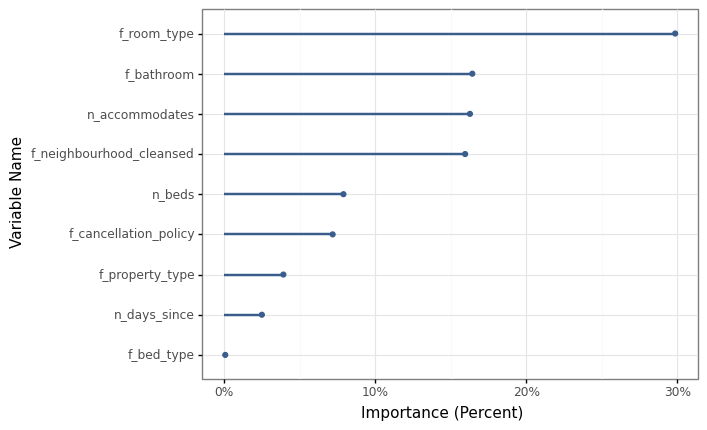

<ggplot: (333833340)>

In [31]:
ggplot(grouped_imp, aes(x="reorder(varname, imp)", y="imp_percentage"),) + geom_point(
    color=color[0], size=1.5
) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

## Partial Dependence Plots 
-------------------------------------------------------


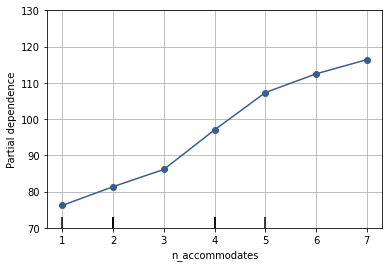

In [32]:
# Note: easy way, sklearn has plot_partial_dependence function
# we do this on holdout set!
plot_partial_dependence(
    rf,
    data_holdout[predictors_2],
    ["n_accommodates"],
    feature_names=data_holdout[predictors_2].columns,
    line_kw={"marker": "o", "color": color[0]},
)
plt.grid()
plt.ylim(70, 130)
plt.show()

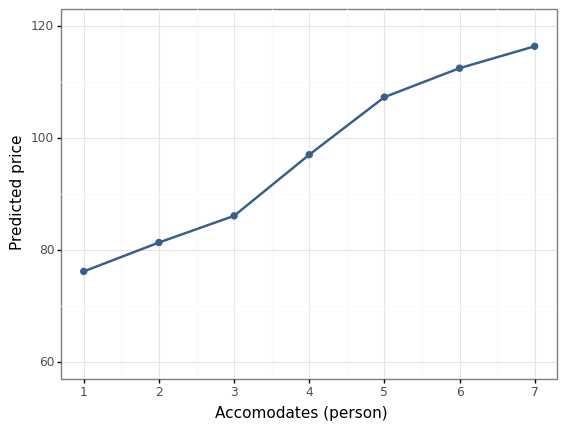

<ggplot: (334069020)>

In [33]:
# replicate the exact book figure with plotnine
accom_pdp = partial_dependence(
    rf, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)

accom_pdp = (
    pd.DataFrame(accom_pdp["average"], columns=accom_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Accomodates (person)"}, axis=1)
)

ggplot(accom_pdp, aes(x="Accomodates (person)", y="Predicted price")) + geom_point(
    color=color[0], size=2
) + geom_line(color=color[0], size=1) + ylim(60, 120) + scale_x_continuous(
    breaks=range(1, 8)
) + theme_bw()

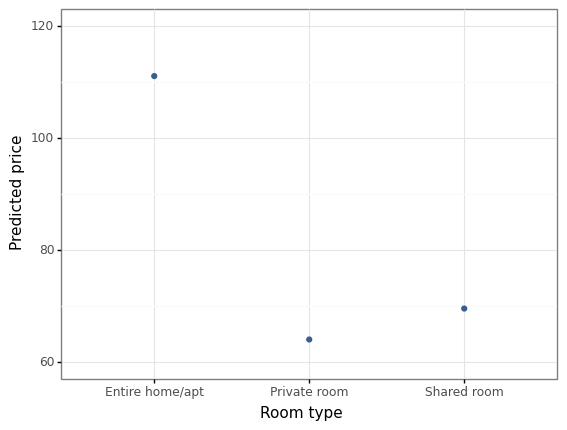

<ggplot: (334064556)>

In [34]:
roomtype_pdp = partial_dependence(
    rf, data_holdout[predictors_2], ["f_room_type"], kind="average"
)

roomtype_pdp = (
    pd.DataFrame(roomtype_pdp["average"], columns=roomtype_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Room type"}, axis=1)
)

ggplot(roomtype_pdp, aes(x="Room type", y="Predicted price")) + geom_point(
    color=color[0]
) + ylim(60, 120) + theme_bw()

### Subsample performance: RMSE / mean(y) 
---------------------------------------
NOTE  we do this on the holdout set.


In [35]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf.predict(data_holdout[predictors_2])
)

create nice summary table of heterogeneity

In [36]:
from sklearn.metrics import mean_squared_error


def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [37]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [38]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        [
            "Westminster",
            "Camden",
            "Kensington and Chelsea",
            "Tower Hamlets",
            "Hackney",
            "Newham",
        ]
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

In [39]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_property_type.isin(["Apartment", "House"])
].groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)

In [40]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
all_holdout.index = ["All"]

In [41]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")

### Table 16.2 Performance across subsamples

In [42]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        all_holdout,
    ]
)

,rmse,mean_price,rmse_norm
Apartment size,,,
large apt,64.9,144.06,0.45
small apt,30.81,62.86,0.49
Type,,,
Apartment,42.81,93.19,0.46
House,50.25,77.49,0.65
Borough,,,
Camden,52.09,105.01,0.5
Hackney,38.6,76.05,0.51
Kensington and Chelsea,65.37,143.55,0.46


## PART IV
### HORSERACE: compare with other models 
-----------------------------------------------
**NOTE: this part of the code is not finished**

1. OLS with dummies for area

 using model B

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [44]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

47.15367981281546

In [45]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

In [46]:
ols_model_coeffs_df

,ols_coefficient
Intercept,-0.000
f_property_type[T.House],7.384
f_room_type[T.Private room],-34.916
f_room_type[T.Shared room],-44.568
f_cancellation_policy[T.moderate],-1.296
...,...
d_tv,6.066
d_washer,-4.694
d_washerdryer,80.073
d_wheelchairaccessible,-1.931


2.  LASSO

using extended model w interactions

In [47]:
from sklearn.linear_model import ElasticNet

The parameter l1_ratio corresponds to alpha in the glmnet R package while alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [48]:
lasso_model =  ElasticNet(l1_ratio = 1,normalize=True,fit_intercept=True)

In [49]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [50]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

In [51]:
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ......................alpha=0.01;, score=-48.060 total time=   0.9s
[CV 2/5] END ......................alpha=0.01;, score=-46.621 total time=   1.1s
[CV 3/5] END ......................alpha=0.01;, score=-47.374 total time=   0.6s
[CV 4/5] END ......................alpha=0.01;, score=-45.666 total time=   0.8s
[CV 5/5] END ......................alpha=0.01;, score=-48.527 total time=   0.5s
[CV 1/5] END ......................alpha=0.02;, score=-49.666 total time=   0.5s
[CV 2/5] END ......................alpha=0.02;, score=-48.011 total time=   0.4s
[CV 3/5] END ......................alpha=0.02;, score=-48.783 total time=   0.4s
[CV 4/5] END ......................alpha=0.02;, score=-47.267 total time=   0.5s
[CV 5/5] END ......................alpha=0.02;, score=-50.198 total time=   0.4s
[CV 1/5] END ......................alpha=0.03;, score=-50.921 total time=   0.3s
[CV 2/5] END ......................alpha=0.03;,

[CV 2/5] END ......................alpha=0.21;, score=-63.643 total time=   0.2s
[CV 3/5] END ......................alpha=0.21;, score=-66.111 total time=   0.2s
[CV 4/5] END ......................alpha=0.21;, score=-64.880 total time=   0.2s
[CV 5/5] END ......................alpha=0.21;, score=-67.910 total time=   0.2s
[CV 1/5] END ......................alpha=0.22;, score=-67.441 total time=   0.2s
[CV 2/5] END ......................alpha=0.22;, score=-64.509 total time=   0.2s
[CV 3/5] END ......................alpha=0.22;, score=-67.022 total time=   0.2s
[CV 4/5] END ......................alpha=0.22;, score=-65.796 total time=   0.2s
[CV 5/5] END ......................alpha=0.22;, score=-68.842 total time=   0.2s
[CV 1/5] END ......................alpha=0.23;, score=-68.368 total time=   0.2s
[CV 2/5] END ......................alpha=0.23;, score=-65.407 total time=   0.2s
[CV 3/5] END ......................alpha=0.23;, score=-67.963 total time=   0.2s
[CV 4/5] END ...............

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1, normalize=True),
             param_grid={'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                                   0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14,
                                   0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21,
                                   0.22, 0.23, 0.24, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [52]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
f_room_type[T.Private room],-34.621
f_room_type[T.Shared room],-28.398
f_cancellation_policy[T.strict],1.787
f_neighbourhood_cleansed[T.City of London],12.601
f_room_type[T.Private room]:f_property_type[T.House],-4.161
f_property_type[T.House]:f_neighbourhood_cleansed[T.Kensington and Chelsea],34.572
n_accommodates,11.893
n_accommodates:f_property_type[T.House],2.031
n_accommodates:f_neighbourhood_cleansed[T.Camden],3.890
n_accommodates:f_neighbourhood_cleansed[T.City of London],1.551


In [54]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

47.24976190971253

3. CART model

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [57]:
cart_model = DecisionTreeClassifier(random_state=2018, criterion="gini")

In [58]:
# Get potential ccp_alpha parameters

path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [59]:
# apply random search to select a "best" alpha 
# RandomizedSearchCV does not calculate all potential alphas, just a random subset

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/vigadam/.local/share/virtualenvs/da_case_studies-A7kE1pOP/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.


[CV 1/5] END ccp_alpha=2.8671368771145135e-05;, score=-61.582 total time=   2.2s
[CV 2/5] END ccp_alpha=2.8671368771145135e-05;, score=-61.532 total time=   1.7s
[CV 3/5] END ccp_alpha=2.8671368771145135e-05;, score=-63.607 total time=   1.8s
[CV 4/5] END ccp_alpha=2.8671368771145135e-05;, score=-65.984 total time=   2.0s
[CV 5/5] END ccp_alpha=2.8671368771145135e-05;, score=-62.293 total time=   1.7s
[CV 1/5] END ccp_alpha=2.8671368771145135e-05;, score=-61.582 total time=   1.7s
[CV 2/5] END ccp_alpha=2.8671368771145135e-05;, score=-61.532 total time=   1.6s
[CV 3/5] END ccp_alpha=2.8671368771145135e-05;, score=-63.607 total time=   1.5s
[CV 4/5] END ccp_alpha=2.8671368771145135e-05;, score=-65.984 total time=   1.6s
[CV 5/5] END ccp_alpha=2.8671368771145135e-05;, score=-62.293 total time=   1.7s
[CV 1/5] END .ccp_alpha=4.558246227527032e-05;, score=-57.358 total time=   2.3s
[CV 2/5] END .ccp_alpha=4.558246227527032e-05;, score=-62.317 total time=   2.5s
[CV 3/5] END .ccp_alpha=4.55

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2018),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 2.40598899e-06, 2.86713688e-06, ...,
       9.49341420e-04, 1.09022941e-03, 1.00707174e-02])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [60]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

59.360669990351504

4. GBM

**NOTE:** These models run for a **very long time** -- needs further investigations.

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbm = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=20)

tune_grid = {"n_estimators": [i for i in range(200, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [ ]:
gbm_pipe.fit(data_train[predictors_2],data_train.price)

the next will be in final model, loads of tuning

In [ ]:
gbm_broad = GradientBoostingClassifier()

In [ ]:
tune_grid = {
    "n_estimators": [i for i in range(50, 500, 50)],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.02, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": [5, 10, 20, 30],
}

gbm_model_cv_broad = GridSearchCV(
    gbm2,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
)

In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe_broad = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv_broad)], verbose=True
)

In [ ]:
gbm_pipe_broad.fit(data_train[predictors_2],data_train.price)